## Introducción 
### Descripción del proyecto
La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

Tienes acceso a los datos de comportamiento de los suscriptores que ya se han cambiado a los planes nuevos (del proyecto del sprint de Análisis estadístico de datos). Para esta tarea de clasificación debes crear un modelo que escoja el plan correcto. Como ya hiciste el paso de procesar los datos, puedes lanzarte directo a crear el modelo.

Desarrolla un modelo con la mayor exactitud posible. En este proyecto, el umbral de exactitud es 0.75. Usa el dataset para comprobar la exactitud.

Instrucciones del proyecto.
Abre y examina el archivo de datos. Dirección al archivo:datasets/users_behavior.csv Descarga el dataset
Segmenta los datos fuente en un conjunto de entrenamiento, uno de validación y uno de prueba.
Investiga la calidad de diferentes modelos cambiando los hiperparámetros. Describe brevemente los hallazgos del estudio.
Comprueba la calidad del modelo usando el conjunto de prueba.
Tarea adicional: haz una prueba de cordura al modelo. Estos datos son más complejos que los que habías usado antes así que no será una tarea fácil. Más adelante lo veremos con más detalle.

## Descripción de los datos
Cada observación en el dataset contiene información del comportamiento mensual sobre un usuario. La información dada es la siguiente:

- `behavior.csv`: cada fila corresponde a un pedido en la aplicación Instacart.
    - `'сalls'`: número de llamada.
    - `'minutes'`: duración total de la llamada en minutos.
    - `'messages'`: número de mensajes de texto.
    - `'mb_used'`: Tráfico de Internet utilizado en MB.
    - `'is_ultra'`: plan para el mes actual (Ultra - 1, Smart - 0).


### Inicialización e importación de librerias 

In [14]:
import pandas as pd

from sklearn.model_selection import train_test_split # Separa los datos en entrenamiento, validación y uno de prueba
from sklearn.ensemble import RandomForestClassifier # Ajuste de hiperparámetros # Bosque aleatorio
from sklearn.metrics import accuracy_score

import datetime
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind
from scipy import stats as st

sns.set_theme()

### Cargar datasets

In [15]:
behavior = pd.read_csv('/datasets/users_behavior.csv')

### Exploración inicial de datos

In [16]:
behavior.info()
behavior.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [17]:
behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
# Analisis de estudio. 
# ver tipo de variable para cada columna (preprocesar en caso de ser necesario)
# calcular el target promedio o graficar histograma
# histograma para cada feature
# histograma para cada feature por clase 

for feature in features:
    plt.figure(figsize=(8,6))
    behavior.query("is_ultra == 0")[feature].hist(label="No", alpha=0.25, ax=plt.gca(), density=True)
    behavior.query("is_ultra == 1")[feature].hist(label="Yes", alpha=0.25, ax=plt.gca(), density=True)
    plt.legend(title="is_ultra")
    plt.ylabel(feature)
    plt.show()

Conclusión, obtenemos todos los histogramas de la clase para cada uno de los features.
- Exploración de datos y analizando el tipo de comportamientos, nos entrega pistas de lo que va aprender nuestro modelo, como va a realizar la predicción.

## Prepara los datos
### Convierte los datos en los tipos necesarios.
- Verifica y corrige los tipos de datos con dtype() 
- Identifica y completa valores ausentes con isna() sum()
- Identifica y elimina los valores duplicados duplicated()  

In [ ]:
type(behavior)

# Identificamos tipos de datos
behavior.dtypes

In [ ]:
# Buscamos valores ausentes y los sumamos
behavior.isna().sum()

In [ ]:
# Contar duplicados explícitos
behavior.duplicated().sum()

## Analiza los datos
### Instrucciones del proyecto
- Segmenta los datos fuente en un conjunto de entrenamiento, uno de validación y uno de prueba.

In [18]:
target = "is_ultra"
features = [c for c in behavior.columns if c not in [target]]

In [19]:
# Verificamos las columnas de la tabla 
features

['calls', 'minutes', 'messages', 'mb_used']

In [20]:
# Separa los datos en entrenamiento, validación y uno de prueba
full_train_df, test_df = train_test_split(
    behavior, 
    test_size=0.18, 
    random_state=88)

train_df, valid_df = train_test_split(
    full_train_df, 
    test_size=0.23, 
    random_state=100)

In [21]:
# Aplicamos len la cantidad de filas para cada una de las tablas entre[]
[len(df) for df in [behavior, full_train_df, train_df, valid_df, test_df]]

[3214, 2635, 2028, 607, 579]

In [22]:
# Verificamos que porcentaje estamos utilizando de la muestra
[round(len(df) / len(behavior), 4) for df in [behavior, full_train_df, train_df, valid_df, test_df]]

[1.0, 0.8199, 0.631, 0.1889, 0.1801]

Conclusiones, 
- Consideramos trabajar con un porcentanje cercano al 65/ 20 / 15 para obtener una cantidad suficiente de datos para cada segmento. 
- Consideramos dividir en 4 grupos la proporcion del 100% de la tabla, para lo cual logramos lo siguiente: 
- full_train_df 0.631 es decir 63.1% de los datos, valid_df validar los datos con el 18.89% y el es test_df con el 18.01%

### Investiga la calidad de diferentes modelos cambiando los hiperparámetros. Describe brevemente los hallazgos del estudio.

### Ajuste de hiperparámetros -  Bosque aleatorio

In [28]:
model =  RandomForestClassifier(n_estimators=100, random_state=100)
    
model.fit(train_df[features], train_df[target])
y_preds = model.predict(valid_df[features])

accuracy_score(valid_df[target], y_preds)

0.7874794069192751

In [24]:
max_score = -100

for n_estims in [50, 100, 150, 200]:
    for max_d in [5, 10, 15]:
    
        model = RandomForestClassifier(n_estimators=n_estims, max_depth=max_d, random_state=100)
    
        model.fit(train_df[features], train_df[target])
        y_preds = model.predict(valid_df[features])
    
        score = accuracy_score(valid_df[target], y_preds)
        
        if score > max_score:
            max_score = score
            print(f"""
            N estimator: {n_estims}
            Max depth: {max_d}
            Accuracy: {score}       
            """)


            N estimator: 50
            Max depth: 5
            Accuracy: 0.7891268533772653       
            

            N estimator: 50
            Max depth: 10
            Accuracy: 0.7924217462932455       
            

            N estimator: 200
            Max depth: 10
            Accuracy: 0.7957166392092258       
            


Conclusión, Imprime el resultado solo si llega a mejorar el desempeño, podemos encontrar la mejor combinación. En este caso la que alcanzo el mejor desempeño es   
            - N estimator: 50
            - Max depth: 5
            - Accuracy: 0.7891268533772653      

### Ajuste de hiperparámetros -   árbol de decisión

In [27]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [31]:
# Mi dataFrame
behavior = pd.read_csv('/datasets/users_behavior.csv')

In [38]:
from sklearn.tree import DecisionTreeClassifier # Ajuste de hiperparámetros # árbol de decisión
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = pd.read_csv('/datasets/users_behavior.csv')

df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345) # segmenta el 25% de los datos para hacer el conjunto de validación

# < crea un bucle para max_depth de 1 a 5 >
for depth in range(1, 6):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # < crea un modelo
        model.fit(features_train, target_train) # < entrena el modelo >
        predictions_valid = model.predict(features_valid) # < encuentra las predicciones usando el conjunto de validación >

        print("max_depth =", depth, ": ", end='')
        print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.8522167487684729
max_depth = 2 : 0.8522167487684729
max_depth = 3 : 0.8466748768472906
max_depth = 4 : 0.8725369458128078
max_depth = 5 : 0.8663793103448276


### Ajuste de hiperparámetros - Regresión logística

In [37]:
from sklearn.linear_model import LogisticRegression # Ajuste de hiperparámetros # Regresión logística
from sklearn.model_selection import train_test_split

df = pd.read_csv('/datasets/users_behavior.csv')

df_train, df_valid = train_test_split(df, test_size=0.25, random_state=54321) # segmenta el 25% de los datos para hacer el conjunto de validación

model = LogisticRegression(random_state=54321, solver='liblinear')# inicializa el constructor de regresión logística con los parámetros 
model.fit(features_train, target_train) # entrena el modelo en el conjunto de entrenamiento
score_train = model.score(features_train, target_train) # calcula la puntuación de accuracy en el conjunto de entrenamiento
score_valid = model.score(features_valid, target_valid) # calcula la puntuación de accuracy en el conjunto de validación

print("Accuracy del modelo de regresión logística en el conjunto de entrenamiento:", score_train)
print("Accuracy del modelo de regresión logística en el conjunto de validación:", score_valid)

Accuracy del modelo de regresión logística en el conjunto de entrenamiento: 0.8811332375282283
Accuracy del modelo de regresión logística en el conjunto de validación: 0.8823891625615764


### Comprueba la calidad del modelo usando el conjunto de prueba.

In [26]:
final_model =  RandomForestClassifier(n_estimators=50,  max_depth=5, random_state=100)
    
final_model.fit(full_train_df[features], full_train_df[target])
test_preds = final_model.predict(test_df[features])

accuracy_score(test_df[target], test_preds)

0.8048359240069085

Conclusión, encontramos un performance de 0.80, que supera el umbral de exactitud es 0.75

In [40]:
%%time
scores = []

for i in range(50): 
    final_model =  RandomForestClassifier(n_estimators=150,  max_depth=10, random_state=100+i)
    
    final_model.fit(full_train_df[features], full_train_df[target])
    test_preds = final_model.predict(test_df[features])

    score = accuracy_score(test_df[target], test_preds)
    scores.append(score)

CPU times: user 42 s, sys: 88.9 ms, total: 42.1 s
Wall time: 42.2 s


Conclusión, estoy entrenando con diferentes semillas aleatorias y estoy trazando un desempeño al que llega mi modelo. Podemos calcular un promedio y la mediana. 

In [41]:
pd.Series(scores).mean()

0.8077720207253887

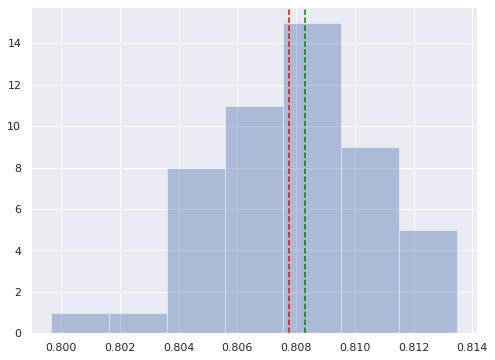

In [42]:
# Metrica mas preciza de reportar el desempeño del promedio del modelo 
pd.Series(scores).hist(bins=7, figsize=(8,6), alpha=0.4)
plt.axvline(x=pd.Series(scores).mean(), color="red", ls="--")
plt.axvline(x=pd.Series(scores).median(), color="green", ls="--")
plt.show()

### Tarea adicional: haz una prueba de cordura al modelo. Estos datos son más complejos que los que habías usado antes así que no será una tarea fácil. Más adelante lo veremos con más detalle.

In [43]:
# Predecir los "1" la probabilidad de acertar
accuracy_score(test_df[target], pd.Series([1] * len(test_df)))

# Seria lo mismo que lo siguiente: 
# (test_df[target] == 1).mean()
# test_df[target].mean()

0.3298791018998273

In [44]:
# Predecir los valores "0" 
accuracy_score(test_df[target], pd.Series([0] * len(test_df)))

# (test_df[target] == 0).mean()

# 1 - test_df[target].mean()

0.6701208981001727

## Conclusiones

- Conclusión de la prueba de cordura, en mis observaciones vemos el 0.67 es decir el 67% de mis datos corresponden a 0 y solo el 32% de las observaciones corresponden a 1. Predecir "1" significa que no me voy a equivocar, vamos acertar al 32% de los casos si estamos prediciendo "1"
- El 67% de los casos si a dar por acertado si predigo que voy a encontrar valores 0